# Experiments for the retraining note

To be published in COPA 2021.

## 1 Testing exchangeability

First we just read the dataset.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# The key parameters: the 3 below plus Ncal (at the end)
rg = np.random.default_rng(0)     # key parameter; setting the seed for reproducibility [default 0]
Jrate = 0.01  # the jumping rate; in the book: 0.001; canonical: 0.01
K = 3  # the number of folds

# reading the data, first red wines
test1 = np.loadtxt("C:/DnB/Work/R/Data/MachineLearning/wine_quality/winequality-red.csv",
  skiprows=1, delimiter=';')
N_test = test1.shape[0]  # 1599, number of red wines
print("Reading",N_test,"= 1599 red wines")
rg.shuffle(test1)  # shuffling the red wines

# reading white wines
white_wines = np.loadtxt("C:/DnB/Work/R/Data/MachineLearning/wine_quality/winequality-white.csv",
  skiprows=1, delimiter=';')
N_white = white_wines.shape[0]  # 4898, number of white wines
print("Reading",N_white,"= 4898 white wines")
rg.shuffle(white_wines)  # shuffling the white wines

test0 = np.copy(white_wines[N_white-N_test:N_white,:])

# Other views of the data:
X_test0 = test0[:,0:11]  # matrix of objects
y_test0 = test0[:,11]    # vector of labels (real numbers)
X_test1 = test1[:,0:11]  # matrix of objects
y_test1 = test1[:,11]    # vector of labels (real numbers)

N_train = N_white - N_test  # the size of the training set

fold = np.array([0,1100,2200])  # the array of starting positions of different folds
fold_size = np.array([1100,1100,1099])  # the array of fold sizes
print("The size of the training set is",N_train,np.sum(fold_size),"= 3299")

# The linear calibrator:
def lin_cal(p,a):
  return 1 + a*(p-0.5)

# My family of calibrators:
Ncal = 3  # the number of calibrators; default 2 or 3
def my_cal(p,k):
  if k==0:
    return lin_cal(p,1)
  if k==1:
    return lin_cal(p,-1)
  if k==2:
    return lin_cal(p,0)
  else:
    print("my_cal failure")

Reading 1599 = 1599 red wines
Reading 4898 = 4898 white wines
The size of the training set is 3299 3299 = 3299


### 1.1 Full Nearest Distance conformity measure

Let us use the distance to the Nearest Neighbour, as for the USPS dataset.
Running time: below 3 mins.

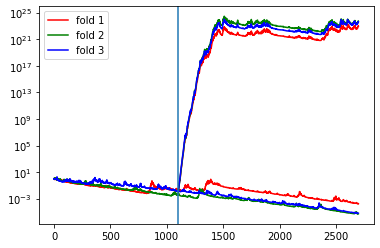

Time elapsed: 151.02236795425415


In [13]:
import time   # for timing
start = time.time()

martingales0 = np.zeros((K,1100+N_test))
martingales1 = np.zeros((K,1100+N_test))
martingales_size = np.zeros(K)

# Going over all folds:
for kkk in range(K):
  current_fold = np.arange(fold[kkk],fold[kkk]+fold_size[kkk])
  calibration = np.copy(white_wines[current_fold])  # calibration set (=current fold)
  N_calibration = calibration.shape[0]   # the size of the calibration set
  rest = np.setdiff1d(np.arange(N_train),current_fold)  # the remaining folds
  train_proper = np.copy(white_wines[rest])  # training set proper
  N_train_proper = train_proper.shape[0]  # the size of the training set proper
  # Other views of the data:
  X_calibration = calibration[:,0:11]  # matrix of objects
  y_calibration = calibration[:,11]    # vector of labels (real numbers)
  X_train_proper = train_proper[:,0:11]  # matrix of objects
  y_train_proper = train_proper[:,11]    # vector of labels (real numbers)
  # Normalization
  scaler = StandardScaler()
  scaler.fit(X_train_proper)
  X_calibration_scaled = scaler.transform(X_calibration)
  X_test0_scaled = scaler.transform(X_test0)
  X_test1_scaled = scaler.transform(X_test1)

  # Computing the p-values:
  N_runs = N_calibration + N_test  # number of runs; remember that N_test is the size of both test0 and test1
  shortest0 = np.inf * np.ones(N_runs)  # shortest distances to the nearest neighbour, scenario 0
  shortest1 = np.inf * np.ones(N_runs)  # shortest distances to the nearest neighbour, scenario 1
  # p is the p-values
  p0 = np.zeros(N_runs)    # p initialized, scenario 0
  p1 = np.zeros(N_runs)    # p initialized, scenario 1

  p0[0] = p1[0] = rg.random()

  for n in range(1,N_calibration):  # the first phase (going over the calibration set)
    for i in range(n):
      Dni = np.linalg.norm(X_calibration_scaled[i,:]-X_calibration_scaled[n,:])
      if Dni < shortest0[i]:
        shortest0[i] = shortest1[i] = Dni
      if Dni < shortest0[n]:
        shortest0[n] = shortest1[n] = Dni
    countG = 0   # the number of alpha's > alpha_n
    countE = 1   # the number of alpha's = alpha_n
    alpha_n = shortest0[n]  # (non)conformity score
    for i in range(n):
      alpha_i = shortest0[i]  # (non)conformity score
      if alpha_i > alpha_n:
        countG = countG+1
      if alpha_i == alpha_n:
        countE = countE+1
    p0[n] = p1[n] = (countG + rg.random() * countE) / (n+1)

  for n in range(N_test):  # the second phase, scenario 0 (going over test0)
    for i in range(N_calibration):  # going over the calibration set
      Dni = np.linalg.norm(X_calibration_scaled[i,:]-X_test0_scaled[n,:])
      if Dni < shortest0[i]:
        shortest0[i] = Dni
      if Dni < shortest0[N_calibration+n]:
        shortest0[N_calibration+n] = Dni
    for i in range(n):  # going over a beginning of test set 0
      Dni = np.linalg.norm(X_test0_scaled[i,:]-X_test0_scaled[n,:])
      if Dni < shortest0[N_calibration+i]:
        shortest0[N_calibration+i] = Dni
      if Dni < shortest0[N_calibration+n]:
        shortest0[N_calibration+n] = Dni
    countG = 0   # the number of alpha's > alpha_n
    countE = 1   # the number of alpha's = alpha_n
    alpha_n = shortest0[N_calibration+n]  # (non)conformity score
    for i in range(N_calibration):   # going over the calibration set
      alpha_i = shortest0[i]  # (non)conformity score
      if alpha_i > alpha_n:
        countG = countG+1
      if alpha_i == alpha_n:
        countE = countE+1
    for i in range(n):  # going over a beginning of test set 0
      alpha_i = shortest0[N_calibration+i]  # (non)conformity score
      if alpha_i > alpha_n:
        countG = countG+1
      if alpha_i == alpha_n:
        countE = countE+1
    p0[N_calibration+n] = (countG + rg.random() * countE) / (N_calibration+n+1)

  for n in range(N_test):  # the second phase, scenario 1 (going over test1)
    for i in range(N_calibration):  # going over the calibration set
      Dni = np.linalg.norm(X_calibration_scaled[i,:]-X_test1_scaled[n,:])
      if Dni < shortest1[i]:
        shortest1[i] = Dni
      if Dni < shortest1[N_calibration+n]:
        shortest1[N_calibration+n] = Dni
    for i in range(n):  # going over a beginning of test set 1
      Dni = np.linalg.norm(X_test1_scaled[i,:]-X_test1_scaled[n,:])
      if Dni < shortest1[N_calibration+i]:
        shortest1[N_calibration+i] = Dni
      if Dni < shortest1[N_calibration+n]:
        shortest1[N_calibration+n] = Dni
    countG = 0   # the number of alpha's > alpha_n
    countE = 1   # the number of alpha's = alpha_n
    alpha_n = shortest1[N_calibration+n]  # (non)conformity score
    for i in range(N_calibration):   # going over the calibration set
      alpha_i = shortest1[i]  # (non)conformity score
      if alpha_i > alpha_n:
        countG = countG+1
      if alpha_i == alpha_n:
        countE = countE+1
    for i in range(n):  # going over a beginning of test set 0
      alpha_i = shortest1[N_calibration+i]  # (non)conformity score
      if alpha_i > alpha_n:
        countG = countG+1
      if alpha_i == alpha_n:
        countE = countE+1
    p1[N_calibration+n] = (countG + rg.random() * countE) / (N_calibration+n+1)

  # Processing test0
  MartCap = np.zeros((Ncal,N_runs))  # the total capital of martingales in each state
  MartCap[:,0] = 1/Ncal  # the initial distribution is uniform
  for i in range(1,N_runs):
    # Jumps mixing starts
    Capital = np.sum(MartCap[:,i-1])
    MartCap[:,i] = (1-Jrate)*MartCap[:,i-1] + (Jrate/Ncal)*Capital
    # Jumps mixing ends
    for k in range(Ncal):
      MartCap[k,i] = MartCap[k,i] * my_cal(p0[i],k)
  martingale = np.sum(MartCap,axis=0)
  my_colors = ['r','g','b']
  plt.plot(martingale,c=my_colors[kkk])
  martingales0[kkk,0:martingale.size] = martingale  # for future use
  martingales_size[kkk] = martingale.size    # for future use

  # Processing test1
  MartCap = np.zeros((Ncal,N_runs))  # the total capital of martingales in each state
  MartCap[:,0] = 1/Ncal  # the initial distribution is uniform
  for i in range(1,N_runs):
    # Jumps mixing starts
    Capital = np.sum(MartCap[:,i-1])
    MartCap[:,i] = (1-Jrate)*MartCap[:,i-1] + (Jrate/Ncal)*Capital
    # Jumps mixing ends
    for k in range(Ncal):
      MartCap[k,i] = MartCap[k,i] * my_cal(p1[i],k)
  martingale = np.sum(MartCap,axis=0)
  plt.plot(martingale,c=my_colors[kkk],label='fold '+str(kkk+1))
  martingales1[kkk,0:martingale.size] = martingale  # for future use

plt.yscale("log")
plt.axvline(x=1100)   # typical size of the calibration set
plt.legend(loc='best')
# plt.savefig("wine.pdf", bbox_inches='tight')
predictor, c_measure = 0, 0  # change the file name (NNdiff to FND)
plt.show()

# print("Final blue value:", martingale2[N-1])

# finding time elapsed in seconds
end = time.time()
print("Time elapsed:", end - start)

# Sound:
import winsound
frequency = 2500  # Set Frequency To 2500 Hertz
duration = 1000  # Set Duration To 1000 ms == 1 second
winsound.Beep(frequency, duration)

### 1.2 Nearest Neighbour, Random Forest, MLP, and SVR inductive conformity measures

Let us now use $|y-\hat y|$ (absdiff) or $y-\hat y$ (diff) for the Nearest Neighbour or Random Forest,
or the PIT (probability integral transform) for the Random Forest.
Running time: 10-15 secs.

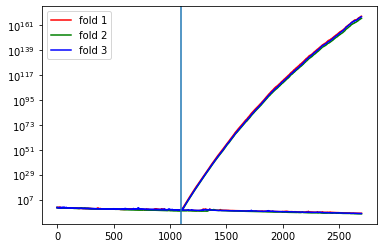

Time elapsed: 10.427018404006958


In [3]:
predictor = 4  # 0 Nearest Neighbour, 1 Random Forest, 2 MLP, 3 SVR, 4 Ilia's Nearest Distance
c_measure = 4  # 0 diff (difference), 1 absdiff (absolute difference), 2 pit (probability integral transform),
  # 3 crps (continuous ranked probability score, not implemented)
  # 4 diff for Ilia's Nearest istance

if predictor==0:
  from sklearn.neighbors import KNeighborsClassifier  # 0.43
elif predictor==1:
  from sklearn.ensemble import RandomForestRegressor  # 0.44
elif predictor==2:
  from sklearn.neural_network import MLPClassifier   # 0.46
elif predictor==3:
  from sklearn.svm import SVR   # 0.50
elif predictor==4:
  from sklearn.neighbors import NearestNeighbors
else:
  print("Invalid predictor")

import time   # for timing
start = time.time()

martingales0 = np.zeros((K,1100+N_test))
martingales1 = np.zeros((K,1100+N_test))
martingales_size = np.zeros(K)

# Going over all folds:
for kkk in range(K):
  current_fold = np.arange(fold[kkk],fold[kkk]+fold_size[kkk])
  calibration = np.copy(white_wines[current_fold])  # calibration set (=current fold)
  N_calibration = calibration.shape[0]   # the size of the calibration set
  rest = np.setdiff1d(np.arange(N_train),current_fold)  # the remaining folds
  train_proper = np.copy(white_wines[rest])  # training set proper
  N_train_proper = train_proper.shape[0]  # the size of the training set proper
  # Other views of the data:
  X_calibration = calibration[:,0:11]  # matrix of objects
  y_calibration = calibration[:,11]    # vector of labels (real numbers)
  X_train_proper = train_proper[:,0:11]  # matrix of objects
  y_train_proper = train_proper[:,11]    # vector of labels (real numbers)
  # Normalization
  scaler = StandardScaler()
  scaler.fit(X_train_proper)
  X_train_proper_scaled = scaler.transform(X_train_proper)
  X_calibration_scaled = scaler.transform(X_calibration)
  X_test0_scaled = scaler.transform(X_test0)
  X_test1_scaled = scaler.transform(X_test1)

  # Computing the p-values:
  N_runs = N_calibration + N_test  # number of runs; remember that N_test is the size of both test0 and test1

  # p is the p-values
  p0 = np.zeros(N_runs)    # p initialized, scenario 0
  p1 = np.zeros(N_runs)    # p initialized, scenario 1

  p0[0] = p1[0] = rg.random()

  ## The key part starts.  First, choose predictor and train it on the training set proper.
  if predictor==0: # 1-Nearest Neighbour
    model = KNeighborsClassifier(n_neighbors=1)
    # model = KNeighborsClassifier(n_neighbors=1, p=1)  # using the Manhattan metric (identical results)
  elif predictor==1: # Random Forest
    n_trees = 100  # the default number of trees is 100
    model = RandomForestRegressor(n_estimators=n_trees,random_state=0)
  elif predictor==2: # Multilayer Perceptron
    model = MLPClassifier(random_state=0) # 0.46 (with warnings)
    # model = MLPClassifier(max_iter=1000,random_state=0)
  elif predictor==3:
    model = SVR()  # 0.50
  elif predictor==4:
    model = NearestNeighbors(n_neighbors=1)
  else:
    print("Failure")
  model.fit(X_train_proper_scaled,y_train_proper)

  ## Evaluating the quality for diff and absdiff:
  if c_measure==0:  # diff
    predictions_calibration = model.predict(X_calibration_scaled)
    predictions_test0 = model.predict(X_test0_scaled)
    predictions_test1 = model.predict(X_test1_scaled)
    conf_scores_calibration = y_calibration - predictions_calibration
    conf_scores_test0 = y_test0 - predictions_test0
    conf_scores_test1 = y_test1 - predictions_test1
  elif c_measure==1:  # absdiff
    predictions_calibration = model.predict(X_calibration_scaled)
    predictions_test0 = model.predict(X_test0_scaled)
    predictions_test1 = model.predict(X_test1_scaled)
    conf_scores_calibration = np.abs(y_calibration - predictions_calibration)
    conf_scores_test0 = np.abs(y_test0 - predictions_test0)
    conf_scores_test1 = np.abs(y_test1 - predictions_test1)
  elif c_measure==2:  # pit (probability integral transform):
    predictions_calibration = np.zeros((n_trees,N_calibration))  # individual trees' predictions initialized
    predictions_test0 = np.zeros((n_trees,N_test))               # individual trees' predictions initialized
    predictions_test1 = np.zeros((n_trees,N_test))               # individual trees' predictions initialized
    conf_scores_calibration = np.zeros(N_calibration)    # (non)conformity scores initialized
    conf_scores_test0 = np.zeros(N_test)                 # (non)conformity scores initialized
    conf_scores_test1 = np.zeros(N_test)                 # (non)conformity scores initialized
    for tree in range(n_trees):  # go over all trees finding their predictions
      predictions_calibration[tree,:] = model.estimators_[tree].predict(X_calibration_scaled)
      predictions_test0[tree,:] = model.estimators_[tree].predict(X_test0_scaled)
      predictions_test1[tree,:] = model.estimators_[tree].predict(X_test1_scaled)
    # use the PITs as (non)conformity scores
    for n in range(N_calibration):
      conf_scores_calibration[n] = np.sum(predictions_calibration[:,n] <= y_calibration[n])
    for n in range(N_test):
      conf_scores_test0[n] = np.sum(predictions_test0[:,n] <= y_test0[n])
      conf_scores_test1[n] = np.sum(predictions_test1[:,n] <= y_test1[n])
  elif c_measure==4:  # only for Ilia's nearest distance
    conf_scores_calibration = np.array(model.kneighbors(X_calibration_scaled))[0,:,0]
    conf_scores_test0 = np.array(model.kneighbors(X_test0_scaled))[0,:,0]
    conf_scores_test1 = np.array(model.kneighbors(X_test1_scaled))[0,:,0]
  else:
    print("Failure")

  for n in range(1,N_calibration):  # the first phase (going over the calibration set)
    countG = 0   # the number of alpha's > alpha_n
    countE = 1   # the number of alpha's = alpha_n
    alpha_n = conf_scores_calibration[n]  # (non)conformity score
    for i in range(n):
      alpha_i = conf_scores_calibration[i]  # (non)conformity score
      if alpha_i > alpha_n:
        countG = countG+1
      if alpha_i == alpha_n:
        countE = countE+1
    p0[n] = p1[n] = (countG + rg.random() * countE) / (n+1)

  for n in range(N_test):  # the second phase, scenario 0 (going over test0)
    countG = 0   # the number of alpha's > alpha_n
    countE = 1   # the number of alpha's = alpha_n
    alpha_n = conf_scores_test0[n]  # (non)conformity score
    for i in range(N_calibration):   # going over the calibration set
      alpha_i = conf_scores_calibration[i]  # (non)conformity score
      if alpha_i > alpha_n:
        countG = countG+1
      if alpha_i == alpha_n:
        countE = countE+1
    for i in range(n):  # going over a beginning of test set 0
      alpha_i = conf_scores_test0[i]  # (non)conformity score
      if alpha_i > alpha_n:
        countG = countG+1
      if alpha_i == alpha_n:
        countE = countE+1
    p0[N_calibration+n] = (countG + rg.random() * countE) / (N_calibration+n+1)

  for n in range(N_test):  # the second phase, scenario 1 (going over test1)
    countG = 0   # the number of alpha's > alpha_n
    countE = 1   # the number of alpha's = alpha_n
    alpha_n = conf_scores_test1[n]  # (non)conformity score
    for i in range(N_calibration):   # going over the calibration set
      alpha_i = conf_scores_calibration[i]  # (non)conformity score
      if alpha_i > alpha_n:
        countG = countG+1
      if alpha_i == alpha_n:
        countE = countE+1
    for i in range(n):  # going over a beginning of test set 0
      alpha_i = conf_scores_test1[i]  # (non)conformity score
      if alpha_i > alpha_n:
        countG = countG+1
      if alpha_i == alpha_n:
        countE = countE+1
    p1[N_calibration+n] = (countG + rg.random() * countE) / (N_calibration+n+1)

  # Processing test0
  MartCap = np.zeros((Ncal,N_runs))  # the total capital of martingales in each state
  MartCap[:,0] = 1/Ncal  # the initial distribution is uniform
  for i in range(1,N_runs):
    # Jumps mixing starts
    Capital = np.sum(MartCap[:,i-1])
    MartCap[:,i] = (1-Jrate)*MartCap[:,i-1] + (Jrate/Ncal)*Capital
    # Jumps mixing ends
    for k in range(Ncal):
      MartCap[k,i] = MartCap[k,i] * my_cal(p0[i],k)
  martingale = np.sum(MartCap,axis=0)
  my_colors = ['r','g','b']
  plt.plot(martingale,c=my_colors[kkk])
  martingales0[kkk,0:martingale.size] = martingale  # for future use
  martingales_size[kkk] = martingale.size    # for future use

  # Processing test1
  MartCap = np.zeros((Ncal,N_runs))  # the total capital of martingales in each state
  MartCap[:,0] = 1/Ncal  # the initial distribution is uniform
  for i in range(1,N_runs):
    # Jumps mixing starts
    Capital = np.sum(MartCap[:,i-1])
    MartCap[:,i] = (1-Jrate)*MartCap[:,i-1] + (Jrate/Ncal)*Capital
    # Jumps mixing ends
    for k in range(Ncal):
      MartCap[k,i] = MartCap[k,i] * my_cal(p1[i],k)
  martingale = np.sum(MartCap,axis=0)
  plt.plot(martingale,c=my_colors[kkk],label='fold '+str(kkk+1))
  martingales1[kkk,0:martingale.size] = martingale  # for future use

plt.yscale("log")
plt.axvline(x=1100)   # typical size of the calibration set
plt.legend(loc='best')
# plt.savefig("wine.pdf", bbox_inches='tight')
plt.show()

# print("Final blue value:", martingale2[N-1])

# finding time elapsed in seconds
end = time.time()
print("Time elapsed:", end - start)

# Sound:
import winsound
frequency = 2500  # Set Frequency To 2500 Hertz
duration = 1000  # Set Duration To 1000 ms == 1 second
winsound.Beep(frequency, duration)

### 1.3 Nicer pictures

If needed, we can easily redraw the Ville picture (since we remembered the martingales).

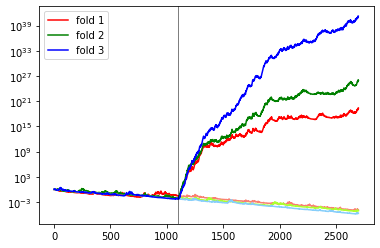

In [3]:
# This code requires the arrays martingales0, martingales 1, and martingales_size
# (and other stuff from the previous cell, such as K)
my_colors = ['r','g','b','salmon','greenyellow','lightskyblue']  # original light red: mistyrose
for kkk in range(K):   # going over all folds
  N = int(martingales_size[kkk])  # number of trials
  # N = 1200   # for partial pictures
  plt.plot(martingales0[kkk,0:N],c=my_colors[kkk+3])   # not informative for smaller N
  plt.plot(martingales1[kkk,0:N],c=my_colors[kkk],label='fold '+str(kkk+1))
  ## the change point under microscope:
  # plt.plot(np.arange(1000,N),martingales0[kkk,1000:N],c=my_colors[kkk+3])
  # plt.plot(np.arange(1000,N),martingales1[kkk,1000:N],c=my_colors[kkk],label='fold '+str(kkk+1))
    
predictors = ["NN","RF","MLP","SVR","IND"]
c_measures = ["diff","absdiff","pit","crps",""]

plt.yscale("log")
plt.axvline(x=1100, linewidth=0.5, c='k')  # typical size of the calibration set
plt.legend(loc='best')
plt.savefig("wine_"+predictors[predictor]+c_measures[c_measure]+"_Ville.pdf", bbox_inches='tight')
plt.show()

Now let me do the Shiryaev-Roberts picture.

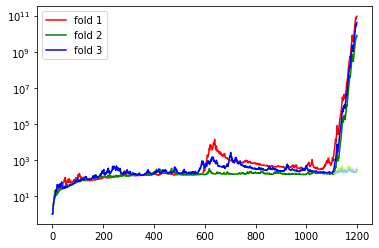

In [20]:
# This code requires the arrays martingales0, martingales 1, and martingales_size
# (and other stuff from the previous cell, such as K)
my_colors = ['r','g','b','mistyrose','greenyellow','lightskyblue']
for kkk in range(K):   # going over all folds
  N = int(martingales_size[kkk])  # number of trials
  N = 1200   # for partial pictures
  SR0 = np.zeros(N)  # Shiryaev-Roberts array, scenario 0
  SR1 = np.zeros(N)  # Shiryaev-Roberts array, scenario 1
  for n in range(1,N):  # going over the time
    SR0[n] = (martingales0[kkk,n]/martingales0[kkk,n-1]) * (SR0[n-1]+1)
    SR1[n] = (martingales1[kkk,n]/martingales1[kkk,n-1]) * (SR1[n-1]+1)
  SR0[0] = SR1[0] = 1   # for a nicer picture
  plt.plot(SR0,c=my_colors[kkk+3])   # not informative for smaller N
  plt.plot(SR1,c=my_colors[kkk],label='fold '+str(kkk+1))

plt.yscale("log")
plt.legend(loc='best')
plt.savefig("wine_"+predictors[predictor]+c_measures[c_measure]+"_SR.pdf", bbox_inches='tight')
plt.show()

Finally, the CUSUM picture.

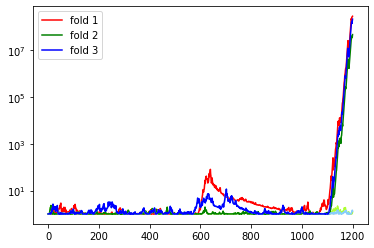

In [21]:
# This code requires the arrays martingales0, martingales 1, and martingales_size
# (and other stuff from the previous cell, such as K)
my_colors = ['r','g','b','mistyrose','greenyellow','lightskyblue']
for kkk in range(K):   # going over all folds
  N = int(martingales_size[kkk])  # number of trials
  N = 1200   # for partial pictures
  CUSUM0 = np.ones(N)  # CUSUM array, scenario 0
  CUSUM1 = np.ones(N)  # CUSUM array, scenario 1
  min_so_far0 = 1  # min so far initialized, scenario 0
  min_so_far1 = 1  # min so far initialized, scenario 1
  for n in range(1,N):  # going over the time
    if martingales0[kkk,n]<min_so_far0:
      min_so_far0 = martingales0[kkk,n]
    if martingales1[kkk,n]<min_so_far1:
      min_so_far1 = martingales1[kkk,n]
    CUSUM0[n] = martingales0[kkk,n] / min_so_far0
    CUSUM1[n] = martingales1[kkk,n] / min_so_far1
    # for a nicer picture:
    if CUSUM0[n]<1:
      CUSUM0[n] = 1
    if CUSUM1[n]<1:
      CUSUM1[n] = 1
  plt.plot(CUSUM0,c=my_colors[kkk+3])   # not informative for smaller N
  plt.plot(CUSUM1,c=my_colors[kkk],label='fold '+str(kkk+1))

plt.yscale("log")
plt.legend(loc='best')
plt.savefig("wine_"+predictors[predictor]+c_measures[c_measure]+"_CUSUM.pdf", bbox_inches='tight')
plt.show()

## 2 Prediction accuracy

Let us first create the data in a format good for scikit-learn.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# The key parameters: the 3 below plus Ncal
rg = np.random.default_rng(0)     # key parameter; setting the seed for reproducibility [default 0]
Jrate = 0.01  # the jumping rate; in the book: 0.001; canonical: 0.01

import time   # for timing
start = time.time()

# reading the data, first red wines
test1 = np.loadtxt("C:/DnB/Work/R/Data/MachineLearning/wine_quality/winequality-red.csv",
  skiprows=1, delimiter=';')
N_test = test1.shape[0]  # 1599, number of red wines
print("Reading",N_test,"= 1599 red wines")
rg.shuffle(test1)  # shuffling the red wines

# reading white wines
white_wines = np.loadtxt("C:/DnB/Work/R/Data/MachineLearning/wine_quality/winequality-white.csv",
  skiprows=1, delimiter=';')
N_white = white_wines.shape[0]  # 4898, number of white wines
print("Reading",N_white,"= 4898 white wines")
rg.shuffle(white_wines)  # shuffling the white wines

test0 = np.copy(white_wines[N_white-N_test:N_white,:])  # test set, scenario 0
train = np.copy(white_wines[0:N_white-N_test])   # training set

# Other views of the data:
X_test0 = test0[:,0:11]  # matrix of objects
y_test0 = test0[:,11]    # vector of labels (real numbers)
X_test1 = test1[:,0:11]  # matrix of objects
y_test1 = test1[:,11]    # vector of labels (real numbers)
X_train = train[:,0:11]  # matrix of objects
y_train = train[:,11]    # vector of labels (real numbers)

N_train = N_white - N_test  # the size of the training set

# Normalization
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test0_scaled = scaler.transform(X_test0)
X_test1_scaled = scaler.transform(X_test1)

# Training 1-Nearest Neighbour:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train_scaled,y_train)

# Evaluating the quality:
predictions0 = knn.predict(X_test0_scaled)
print("Accuracy in scenario 0:",np.mean(np.abs(y_test0-predictions0)))
predictions1 = knn.predict(X_test1_scaled)
print("Accuracy in scenario 1:",np.mean(np.abs(y_test1-predictions1)))

Reading 1599 = 1599 red wines
Reading 4898 = 4898 white wines
Accuracy in scenario 0: 0.4333958724202627
Accuracy in scenario 1: 1.020637898686679


### 2.1 The algorithms from CS3920

First the prediction accuracy of K-Nearest Neighbours.

In [23]:
# Training 1-Nearest Neighbour:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
# knn = KNeighborsClassifier(n_neighbors=1, p=1)  # using the Manhattan metric (identical results)
knn.fit(X_train_scaled,y_train)

# Evaluating the quality:
predictions0 = knn.predict(X_test0_scaled)
print("Accuracy in scenario 0:",np.mean(np.abs(y_test0-predictions0)))
predictions1 = knn.predict(X_test1_scaled)
print("Accuracy in scenario 1:",np.mean(np.abs(y_test1-predictions1)))

Accuracy in scenario 0: 0.4333958724202627
Accuracy in scenario 1: 1.020637898686679


Now let us try Least Squares.

In [58]:
from sklearn.linear_model import LinearRegression
ls = LinearRegression().fit(X_train_scaled,y_train)

# Evaluating the quality:
predictions0 = ls.predict(X_test0_scaled)
print("Accuracy in scenario 0:",np.mean(np.abs(y_test0-predictions0)))
predictions1 = ls.predict(X_test1_scaled)
print("Accuracy in scenario 1:",np.mean(np.abs(y_test1-predictions1)))

Accuracy in scenario 0: 0.5682556111095313
Accuracy in scenario 1: 0.8530985599133285


Next Ridge Regression.

In [59]:
from sklearn.linear_model import Ridge
ridge = Ridge().fit(X_train_scaled,y_train)
# ridge = Ridge(alpha=0.1).fit(X_train_scaled,y_train)  # the default (in the line above) is alpha=1

# Evaluating the quality:
predictions0 = ridge.predict(X_test0_scaled)
print("Accuracy in scenario 0:",np.mean(np.abs(y_test0-predictions0)))
predictions1 = ridge.predict(X_test1_scaled)
print("Accuracy in scenario 1:",np.mean(np.abs(y_test1-predictions1)))

Accuracy in scenario 0: 0.5682413189928388
Accuracy in scenario 1: 0.8503781756296318


Now the Lasso.

In [60]:
from sklearn.linear_model import Lasso
lasso = Lasso().fit(X_train_scaled,y_train)

# Evaluating the quality:
predictions0 = lasso.predict(X_test0_scaled)
print("Accuracy in scenario 0:",np.mean(np.abs(y_test0-predictions0)))
predictions1 = lasso.predict(X_test1_scaled)
print("Accuracy in scenario 1:",np.mean(np.abs(y_test1-predictions1)))

Accuracy in scenario 0: 0.6575445664452679
Accuracy in scenario 1: 0.6655284894071223


Next Nearest Neighbour with the polynomial and RBF kernels.
(This takes some time, more than a minute for the polynomial and more than 4 mins for RBF!)

In [68]:
import time   # for timing
start = time.time()

def poly_kernel(x,y,d):
  return (1+np.dot(x,y))**d
d = 3 # trying the polynomial kernel of degree d
def poly_dist(x,y): # squared distance
  return poly_kernel(x,x,d) + poly_kernel(y,y,d) - 2*poly_kernel(x,y,d)

def rbf_kernel(x,y,gamma):
  return np.exp(-gamma*np.sum((x-y)**2))
gamma = 10 # the parameter gamma of the rbf kernel
def rbf_dist(x,y): # squared distance
  return rbf_kernel(x,x,gamma) + rbf_kernel(y,y,gamma) - 2*rbf_kernel(x,y,gamma)

knn = KNeighborsClassifier(n_neighbors=1, metric=rbf_dist)
knn.fit(X_train_scaled,y_train)

# Evaluating the quality:
predictions0 = knn.predict(X_test0_scaled)
print("Accuracy in scenario 0:",np.mean(np.abs(y_test0-predictions0)))
predictions1 = knn.predict(X_test1_scaled)
print("Accuracy in scenario 1:",np.mean(np.abs(y_test1-predictions1)))

# finding time elapsed in seconds
end = time.time()
print("Time elapsed:", end - start)

Accuracy in scenario 0: 0.43964978111319575
Accuracy in scenario 1: 0.734208880550344
Time elapsed: 266.04176688194275


Next neural nets (without using the boundedness of the label).

In [15]:
import time   # for timing
start = time.time()

from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(random_state=0).fit(X_train_scaled, y_train) # 0.46 (9 secs)
# mlp = MLPClassifier(max_iter=1000,random_state=0).fit(X_train_scaled, y_train) # 0.48 (33 secs)
# default max_iter is 200; there was a warning that it's not enough
# mlp = MLPClassifier(hidden_layer_sizes=[10]).fit(X_train_scaled, y_train) # 0.48
# mlp = MLPClassifier(solver='lbfgs',hidden_layer_sizes=[10]).fit(X_train_scaled, y_train) # 0.47
# mlp = MLPClassifier(solver='lbfgs',hidden_layer_sizes=[10],activation='tanh').fit(X_train_scaled, y_train) # 0.51
# the default for the hidden layer sizes is 100; there are warnings about non-convergence
# the options are as in CS3920, Lab 8
mlp.fit(X_train_scaled,y_train)

# Evaluating the quality:
predictions0 = mlp.predict(X_test0_scaled)
print("Accuracy in scenario 0:",np.mean(np.abs(y_test0-predictions0)))
predictions1 = mlp.predict(X_test1_scaled)
print("Accuracy in scenario 1:",np.mean(np.abs(y_test1-predictions1)))

# finding time elapsed in seconds
end = time.time()
print("Time elapsed:", end - start)

C:\Users\uhac013\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Accuracy in scenario 0: 0.4627892432770482
Accuracy in scenario 1: 1.3114446529080674
Time elapsed: 8.413755655288696


C:\Users\uhac013\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Next linear Support Vector Regression.

In [17]:
import time   # for timing
start = time.time()

from sklearn.svm import LinearSVR
# svr = LinearSVR(random_state=0).fit(X_train_scaled, y_train)  # 0.56
svr = LinearSVR(max_iter=10000).fit(X_train_scaled, y_train)  # 0.56
# the default is max_iter=1000; there was a warning that it's not enough

# Evaluating the quality:
predictions0 = svr.predict(X_test0_scaled)
print("Accuracy in scenario 0:",np.mean(np.abs(y_test0-predictions0)))
predictions1 = svr.predict(X_test1_scaled)
print("Accuracy in scenario 1:",np.mean(np.abs(y_test1-predictions1)))

# finding time elapsed in seconds
end = time.time()
print("Time elapsed:", end - start)

Accuracy in scenario 0: 0.5638472168918702
Accuracy in scenario 1: 0.9061655243387144
Time elapsed: 0.06906890869140625


Next kernel Support Vector Regression.

In [19]:
import time   # for timing
start = time.time()

from sklearn.svm import SVR
svr = SVR().fit(X_train_scaled, y_train)  # 0.50

# Evaluating the quality:
predictions0 = svr.predict(X_test0_scaled)
print("Accuracy in scenario 0:",np.mean(np.abs(y_test0-predictions0)))
predictions1 = svr.predict(X_test1_scaled)
print("Accuracy in scenario 1:",np.mean(np.abs(y_test1-predictions1)))

# finding time elapsed in seconds
end = time.time()
print("Time elapsed:", end - start)

Accuracy in scenario 0: 0.49970530374085453
Accuracy in scenario 1: 0.8056433845301944
Time elapsed: 0.6361479759216309


Now let's try decision trees.

In [20]:
from sklearn.tree import DecisionTreeRegressor
tree = DecisionTreeRegressor()
tree.fit(X_train_scaled, y_train)

# Evaluating the quality:
predictions0 = tree.predict(X_test0_scaled)
print("Accuracy in scenario 0:",np.mean(np.abs(y_test0-predictions0)))
predictions1 = tree.predict(X_test1_scaled)
print("Accuracy in scenario 1:",np.mean(np.abs(y_test1-predictions1)))

Accuracy in scenario 0: 0.5240775484677924
Accuracy in scenario 1: 1.2883051907442151


Now we enhance decision trees to the random forest.

In [20]:
from sklearn.ensemble import RandomForestRegressor
# forest = RandomForestRegressor(n_estimators=10,random_state=0)  # 10,000 is too long
forest = RandomForestRegressor(random_state=0)  # 0.44
# default: n_estimators = 100
# 10,000 estimators: 0.436
# 1000 estimators: 0.437
# 100 estimators: 0.439 (default)
# 10 estimator: 0.470 (this was the defaut before scikit-learn 0.22)
forest.fit(X_train_scaled, y_train)

# Evaluating the quality:
predictions0 = forest.predict(X_test0_scaled)
print("Accuracy in scenario 0:",np.mean(np.abs(y_test0-predictions0)))
predictions1 = forest.predict(X_test1_scaled)
print("Accuracy in scenario 1:",np.mean(np.abs(y_test1-predictions1)))

Accuracy in scenario 0: 0.43865540963101934
Accuracy in scenario 1: 0.9235021888680425


Finally, Gradient Boosting (the other algorithms are for classification).

In [33]:
from sklearn.ensemble import GradientBoostingRegressor
# gb = GradientBoostingRegressor(random_state=0)  # 0.521
# gb = GradientBoostingRegressor(random_state=0,max_depth=1)  # 0.568
gb = GradientBoostingRegressor(random_state=0,learning_rate=0.01)  # 0.585
gb.fit(X_train_scaled, y_train)

# Evaluating the quality:
predictions0 = gb.predict(X_test0_scaled)
print("Accuracy in scenario 0:",np.mean(np.abs(y_test0-predictions0)))
predictions1 = gb.predict(X_test1_scaled)
print("Accuracy in scenario 1:",np.mean(np.abs(y_test1-predictions1)))

Accuracy in scenario 0: 0.5847703057888618
Accuracy in scenario 1: 0.6116563187350572


### 2.2 Other algorithms from scikit-learn

On 31 January 2021 I went over all the regression algorithms in scikit-learn.
None of them was comparable with Nearest Neighbour or Random Forest (the best two in CS3920).

Kernel Ridge Regression:

In [38]:
from sklearn.kernel_ridge import KernelRidge
# krr = KernelRidge()  # hopeless
krr = KernelRidge(kernel='rbf')
# krr = KernelRidge(alpha=1.0)  # alpha=1.0 is the default
krr.fit(X_train_scaled, y_train)

# Evaluating the quality:
predictions0 = krr.predict(X_test0_scaled)
print("Accuracy in scenario 0:",np.mean(np.abs(y_test0-predictions0)))
predictions1 = krr.predict(X_test1_scaled)
print("Accuracy in scenario 1:",np.mean(np.abs(y_test1-predictions1)))

Accuracy in scenario 0: 0.5731677609398776
Accuracy in scenario 1: 3.2799824082669207


Stochastic Gradient Desecent:

In [44]:
from sklearn.linear_model import SGDRegressor
sgd = SGDRegressor(random_state=0)  # 0.571
# sgd = SGDRegressor(max_iter=1000, tol=1e-3)  # example given in the scikit-learn documentation # 0.569
sgd.fit(X_train_scaled, y_train)

# Evaluating the quality:
predictions0 = sgd.predict(X_test0_scaled)
print("Accuracy in scenario 0:",np.mean(np.abs(y_test0-predictions0)))
predictions1 = sgd.predict(X_test1_scaled)
print("Accuracy in scenario 1:",np.mean(np.abs(y_test1-predictions1)))

Accuracy in scenario 0: 0.5711104655844796
Accuracy in scenario 1: 0.7317972624077808


Gaussian Process Regression:

In [46]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
kernel = DotProduct() + WhiteKernel()   # example given in the scikit-learn documentation # 0.568
# gpr = GaussianProcessRegressor(kernel=kernel,random_state=0).fit(X_train_scaled,y_train)
gpr = GaussianProcessRegressor(random_state=0).fit(X_train_scaled,y_train)   # 0.864

# Evaluating the quality:
predictions0 = gpr.predict(X_test0_scaled)
print("Accuracy in scenario 0:",np.mean(np.abs(y_test0-predictions0)))
predictions1 = gpr.predict(X_test1_scaled)
print("Accuracy in scenario 1:",np.mean(np.abs(y_test1-predictions1)))

Accuracy in scenario 0: 0.8636093796150162
Accuracy in scenario 1: 5.336619526745221


## 3 Sandbox